In [1]:
import os
import glob
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [2]:
def read_img(path):
    img = mpimg.imread(path)
    if ".png" in path:
        img = img * 255
    return img

def show(img, cmap=None):
    if np.max(img) <= 1:
        plt.imshow(img, cmap=cmap)
    else:
        # plt requires normalized images
        plt.imshow(img / 255.0, cmap=cmap)

# Read Data

In [3]:
def load_test(convertToFile=False):
    files =  glob.glob("test_images/*.jpg")
    if convertToFile:
        files = [mpimg.imread(x) for x in files]
    return files

def load_non_vehicles(convertToFile=False):
    files = glob.glob("data/non-vehicles/Extras/*.png")
    files += glob.glob("data/non-vehicles/GTI/*.png")
    if convertToFile:
        # mpimg read png as 0-1, let's scale them up 0-255
        files = [mpimg.imread(x) * 255 for x in files]
    return files, np.zeros(len(files))

def load_vehicles(convertToFile=False, GTI=True, KITTI=True):
    files = []
    if GTI:
        files += glob.glob("data/vehicles/GTI_Far/*.png")
        files += glob.glob("data/vehicles/GTI_Left/*.png")
        files += glob.glob("data/vehicles/GTI_MiddleClose/*.png")
        files += glob.glob("data/vehicles/GTI_Right/*.png")
    if KITTI:
        files += glob.glob("data/vehicles/KITTI_extracted/*.png")
    if convertToFile:
        # mpimg read png as 0-1, let's scale them up 0-255
        files = [mpimg.imread(x) * 255 for x in files]
    return files, np.ones(len(files))

In [4]:
if "test_images.p" not in os.listdir("."):
    test_images = load_test(True)
    pickle.dump(test_images, open("test_images.p", "wb"))
else:
    test_images = pickle.load(open("test_images.p", "rb"))
print(len(test_images), "test images loaded")
                               
if "non_vehicles.p" not in os.listdir("."):
    non_vehicles = load_non_vehicles(True)
    pickle.dump(non_vehicles, open("non_vehicles.p", "wb"))
else:
    non_vehicles = pickle.load(open("non_vehicles.p", "rb"))
print(len(non_vehicles[0]), "non_vehicles images loaded")

if "vehicles.p" not in os.listdir("."):
    vehicles = load_vehicles(True)
    pickle.dump(vehicles, open("vehicles.p", "wb"))
else:
    vehicles = pickle.load(open("vehicles.p", "rb"))
print(len(vehicles[0]), "vehicles images loaded")

6 test images loaded
8968 non_vehicles images loaded
8792 vehicles images loaded


In [5]:
non_vehicles_X, non_vehicles_y = non_vehicles
vehicles_X, vehicles_y = vehicles
# Change to numpy array type
test_images = np.array(test_images)
non_vehicles_X, non_vehicles_y = np.array(non_vehicles_X), np.array(non_vehicles_y)
vehicles_X, vehicles_y = np.array(vehicles_X), np.array(vehicles_y)


# Histogram of Oriented Gradients (HOG)

In [6]:
def bin_spatial(img, size=(32, 32)):
    """
    A function to compute binned color features.
    Resize the feature vector (1, M x N) to size (M, N)
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256), featureOnly=True):
    """A function to compute color histogram features """
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    if featureOnly:
        return hist_features
    else:
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features

    
def get_hog_features(img, numOrient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """A function to return HOG features and visualization"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=numOrient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=numOrient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [7]:
def single_img_features(img, color_space='HSV', spatial_size=(16, 16),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False, feature_vec=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec))
        else:
            if vis:
                res = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=feature_vec)
                hog_features.extend(res[0])
                hog_image = res[1]
            else:
                hog_features.extend(get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec))
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    if vis and hog_feat and hog_channel != "ALL":
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features).astype(np.float64)

In [8]:
def demonstrate_features(img_vehicle, color_space="RGB", spatial_size=(16,16), hist_bins=16, 
                         orient=8, pix_per_cell=8, cell_per_block=2, spatial_feat=True, 
                         hist_feat=True, hog_feat=True, vis=True, feature_vec=True):

    plt.figure(figsize=(15,7))
    # original image
    plt.subplot(241)
    plt.title("original")
    show(img_vehicle)
    # hog with first channel
    hog0, hog0_img = single_img_features(img_vehicle, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                        vis=vis, feature_vec=feature_vec, hog_channel=0)
    plt.subplot(242)
    plt.title("ch=0")
    show(hog0_img, cmap="hot")
    # hog with second channel
    hog1, hog1_img = single_img_features(img_vehicle, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                        vis=vis, feature_vec=feature_vec, hog_channel=1)
    plt.subplot(243)
    plt.title("ch=1")
    show(hog1_img, cmap="hot")
    # hog with third channel
    hog2, hog2_img = single_img_features(img_vehicle, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                        vis=vis, feature_vec=feature_vec, hog_channel=2)
    plt.subplot(244)
    plt.title("ch=2")
    show(hog2_img, cmap="hot")
    
    title = "color_space {0}; spatial_size {1}; hist_bins {2}; orient {3}; pix_per_cell {4}; cell_per_block {5}".format(color_space, spatial_size, 
                                                                 hist_bins, orient, pix_per_cell,cell_per_block)
    plt.suptitle(title)

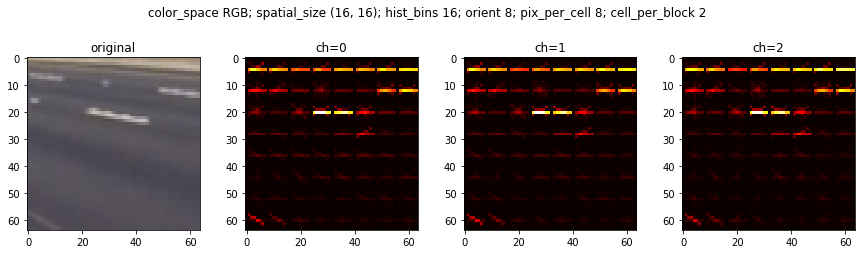

In [9]:
demonstrate_features(non_vehicles_X[140], color_space="RGB")

### Explore Different Color Spaces

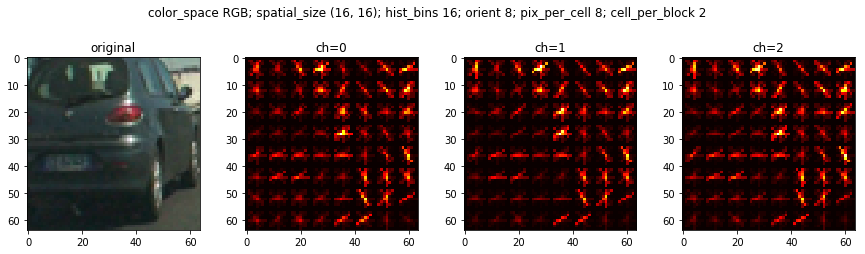

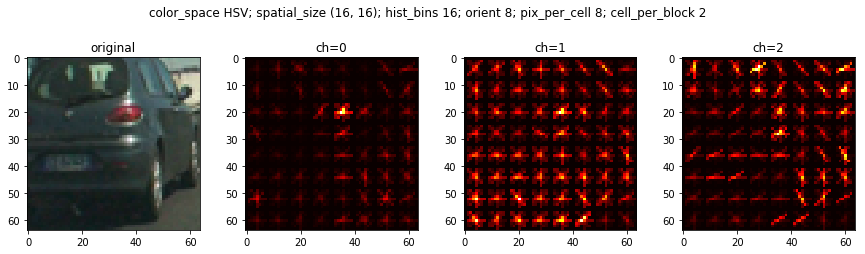

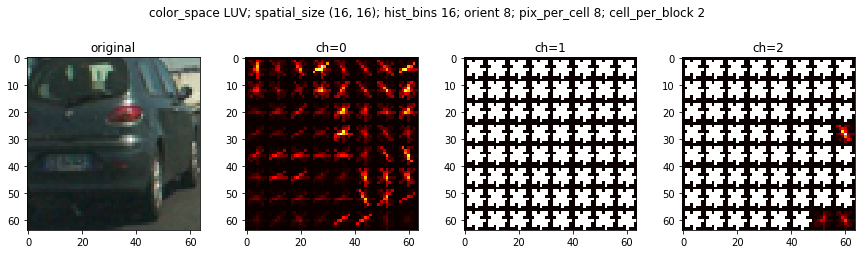

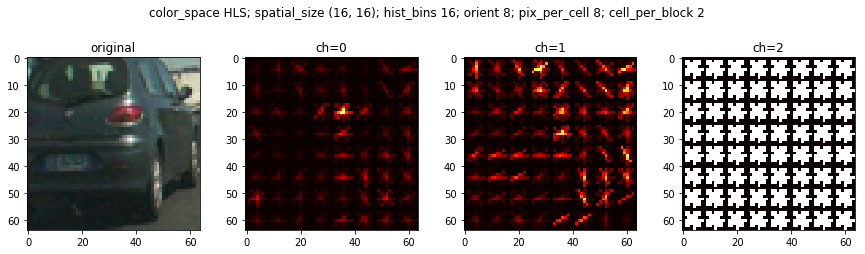

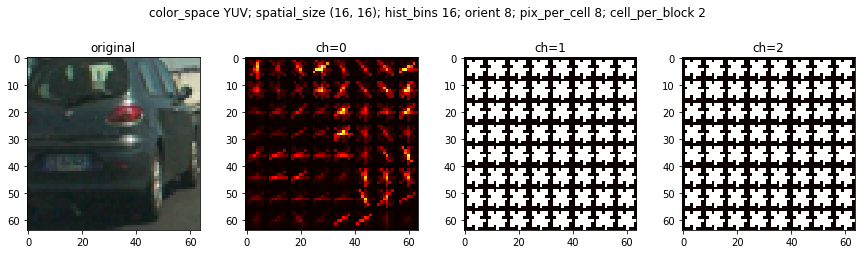

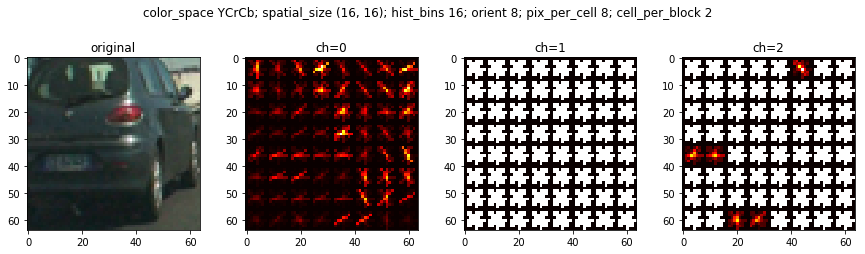

In [10]:
# RGB, HSV, LUV, HLS, YUV, YCrCb
img_to_demonstrate = vehicles_X[1249]
demonstrate_features(img_to_demonstrate, color_space="RGB")
demonstrate_features(img_to_demonstrate, color_space="HSV")
demonstrate_features(img_to_demonstrate, color_space="LUV")
demonstrate_features(img_to_demonstrate, color_space="HLS")
demonstrate_features(img_to_demonstrate, color_space="YUV")
demonstrate_features(img_to_demonstrate, color_space="YCrCb")

It seems that the first channel of either LUV, YUV, YCrCb; second channel of HLS; last channel of hSV all work fine

### Explore Different Hog Parameters

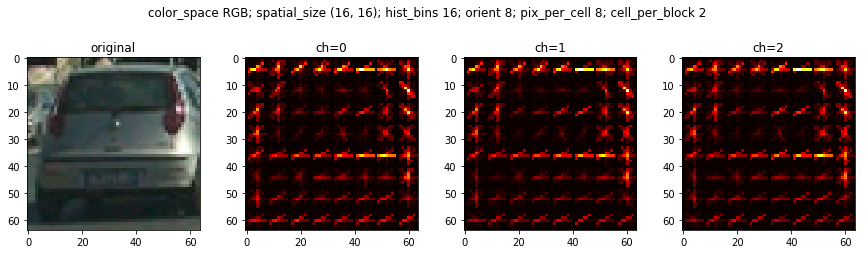

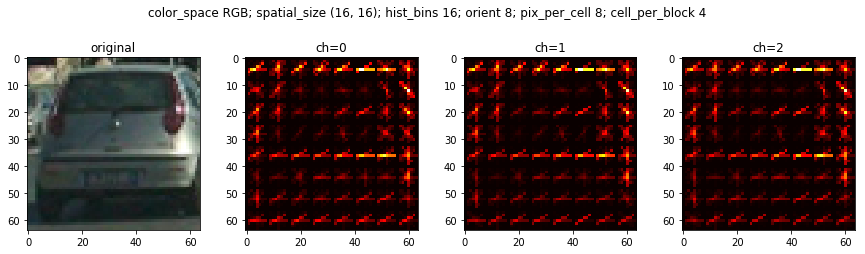

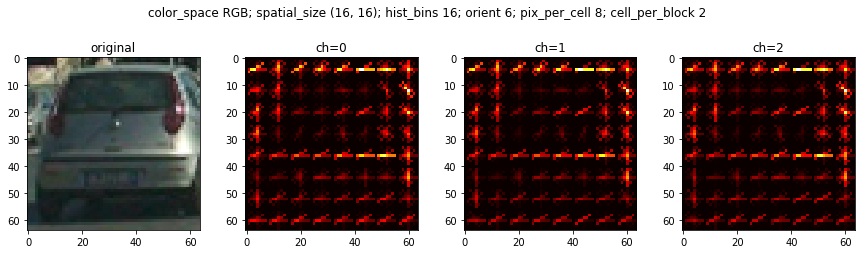

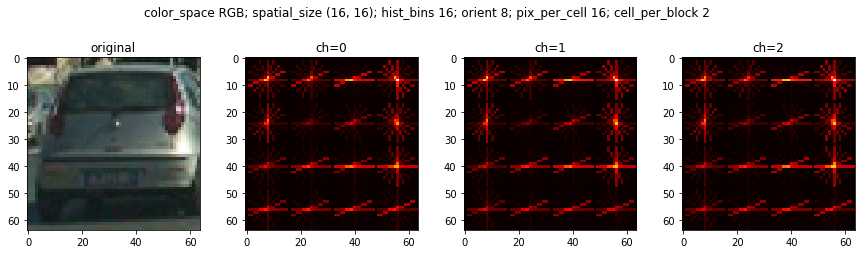

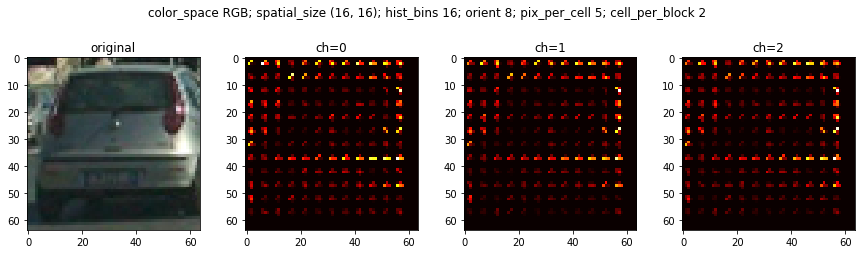

In [11]:
# RGB, HSV, LUV, HLS, YUV, YCrCb
img_to_demonstrate = vehicles_X[1224]
demonstrate_features(img_to_demonstrate)
demonstrate_features(img_to_demonstrate, color_space="RGB", cell_per_block=4)
demonstrate_features(img_to_demonstrate, color_space="RGB", orient=6)
demonstrate_features(img_to_demonstrate, color_space="RGB", pix_per_cell=16)
demonstrate_features(img_to_demonstrate, color_space="RGB", pix_per_cell=5)

It looks like generally, cell_per_block doesn't have huge effect, but we definitely don't want too many orient nor pixel_per_cell.

### Explore Color Histogram

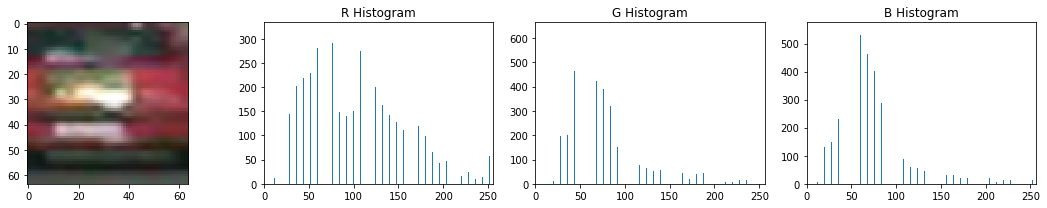

In [12]:
hist_img_to_show = vehicles_X[15]
rh, gh, bh, bin_centers, hist_features = color_hist(hist_img_to_show, featureOnly=False)

fig = plt.figure(figsize=(15,3))
plt.subplot(141)
plt.imshow(hist_img_to_show / 255.0)
plt.subplot(142)
plt.title('R Histogram')
plt.bar(bin_centers, rh[0])
plt.xlim(0, 256)
plt.subplot(143)
plt.bar(bin_centers, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(144)
plt.bar(bin_centers, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

### Train a classifier

In [13]:
X = np.vstack([non_vehicles_X, vehicles_X])
y = np.hstack([non_vehicles_y, vehicles_y])
print(X.shape, y.shape)

(17760, 64, 64, 3) (17760,)


In [14]:
def extract_features(imgs, color_space="YCrCb", spatial_size=(16,16), hist_bins=32, 
                         orient=9, pix_per_cell=8, cell_per_block=2, spatial_feat=True, 
                         hist_feat=True, hog_feat=True, vis=False, feature_vec=True,
                        hog_channel=0):
    features = []
    for i, img in enumerate(imgs):
        print("progress: {0}/{1}".format(i+1, len(imgs)), end="\r")
        features.append(single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                        vis=vis, feature_vec=feature_vec, hog_channel=hog_channel))
    return np.array(features)

In [15]:
def train(X, y, model, saveName="model.p", save=True, cross_val=True, k=5):
    model.fit(X, y)
    if save:
        pickle.dump(model, open(saveName, "wb"))
    if cross_val:
        scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
        return model, scores.mean()
    else:
        return model

def accuracy(X, y, model):
    return model.score(X, y)

def normalize(X):
    X = X.astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    return X_scaler, X_scaler.transform(X)

def load_model(model):
    return pickle.load(open(model, "rb"))

In [16]:
def split_data(X, y, test_size=0.2):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=rand_state)
    return X_train, X_test, y_train, y_test

In [246]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [247]:
rand_ind = np.random.randint(0, len(X_train), size=10000)
X_train = X_train[rand_ind]
y_train = y_train[rand_ind]
print("noncar label:", sum([1 for x in y_train if x == 0]))
print("car label:", sum([1 for x in y_train if x == 1]))

noncar label: 4997
car label: 5003


In [248]:
X_train_features = extract_features(X_train)

In [249]:
X_scaler, X_train_features = normalize(X_train_features)

In [250]:
X_train_features.shape

(10000, 2628)

In [251]:
y_train.shape

(10000,)

In [252]:
model = LinearSVC()

In [253]:
retrain = True
if "model_trained.p" not in os.listdir(".") or retrain:
    model_trained, model_train_acc = train(X_train_features, y_train, model, saveName="model_trained.p", save=True)
else:
    model_trained = pickle.load(open("model_trained.p", "rb"))
    print("model loaded...")

In [254]:
print("train accuracy:", model_train_acc)

train accuracy: 0.98930019785


In [255]:
X_test_features = X_scaler.transform(extract_features(X_test))

In [256]:
X_test_features.shape

(3552, 2628)

In [257]:
y_test.shape

(3552,)

In [258]:
print("test accuracy:", accuracy(X_test_features, y_test, model_trained))

test accuracy: 0.981981981982


In [259]:
n_predict = 10
print('My SVC predicts: ', model_trained.predict(X_test_features[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  0.  1.  1.  0.]


Test the classifier

model from [ 0.  1.]


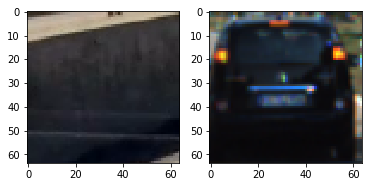

In [260]:
test_imgs = [X[2352], X[-24]]
plt.subplot(121)
show(test_imgs[0])
plt.subplot(122)
show(test_imgs[1])

print("model from", model_trained.predict(X_scaler.transform(extract_features(test_imgs))))

### Sliding Window Search

In [261]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 window_size=(64, 64), overlap_ratio=(0.5, 0.5)):
    """
    Return the window coordinates used for search
    """
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(window_size[0]*(1 - overlap_ratio[0]))
    ny_pix_per_step = np.int(window_size[1]*(1 - overlap_ratio[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(window_size[0]*(overlap_ratio[0]))
    ny_buffer = np.int(window_size[1]*(overlap_ratio[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + window_size[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + window_size[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [262]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, X_scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features([test_img])[0]
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [263]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

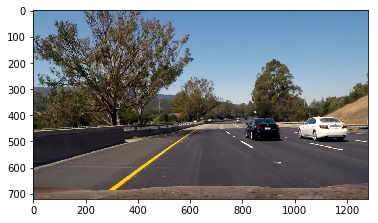

In [264]:
test_search_img = test_images[0]
show(test_search_img)

In [290]:
def find_car_single_image(test_search_img, model_trained, X_scaler, x_search_range=[500, None], 
                          y_search_range=[400, None], window_size=(64,64), overlap_ratio=(0.7,0.7),
                          box_color=(0,255,0), thick=5, vis=True):
    
    windows = slide_window(test_search_img, x_start_stop=x_search_range, y_start_stop=y_search_range, 
                    window_size=window_size, overlap_ratio=overlap_ratio)

    hot_windows = search_windows(test_search_img, windows, model_trained, X_scaler)   

    window_img = draw_boxes(test_search_img, hot_windows, color=box_color, thick=thick)                    
    
    if vis:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title("original")
        show(test_search_img)
        plt.subplot(122)
        plt.title("boxes")
        show(window_img)
    return window_img, hot_windows

In [291]:
test_images[0].shape

(720, 1280, 3)

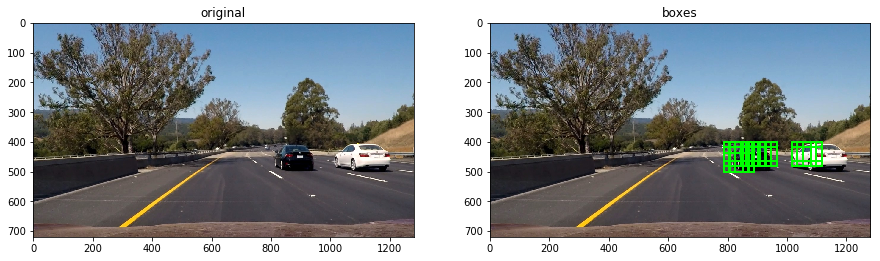

In [307]:
_, _ = find_car_single_image(test_images[0], model_trained, X_scaler, vis=True)

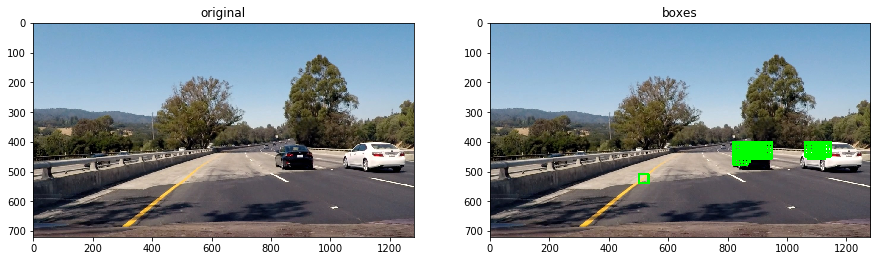

In [310]:
_, _ = find_car_single_image(test_images[2], model_trained, X_scaler,window_size=(32,32), vis=True)

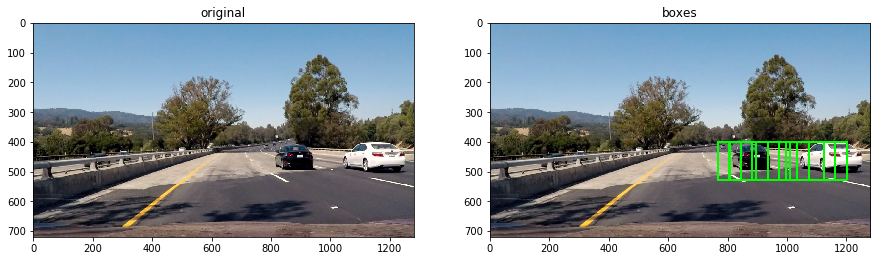

In [311]:
_, _ = find_car_single_image(test_images[2], model_trained, X_scaler,window_size=(128,128), vis=True)

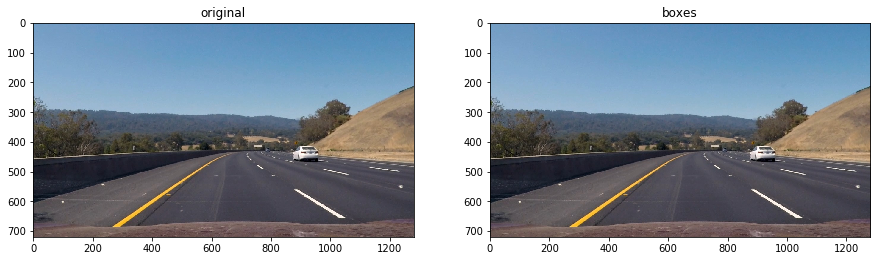

In [341]:
_, _ = find_car_single_image(test_images[4], model_trained, X_scaler, vis=True)

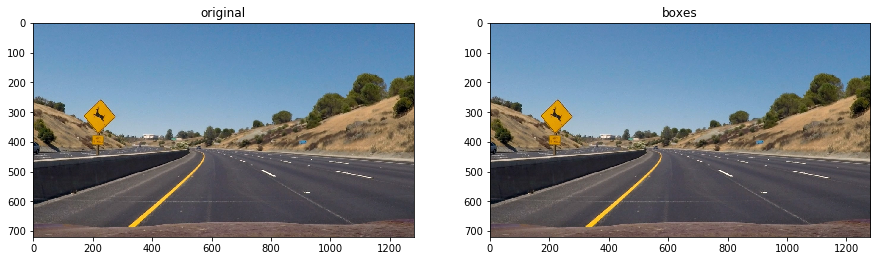

In [295]:
_, _ = find_car_single_image(test_images[5], model_trained, X_scaler, vis=True)

In [300]:
def draw_heatmap(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    return add_heat(heatmap, bbox_list)

def add_heat(heatmap, bbox_list):
    """Return a heatmap from a list of bonding boxes"""
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap # Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """Filter heatmap based on treshold"""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_bboxes_from_heatmap(img, heatmap):
    """Draw bonding boxes from heatmap"""
    img = np.copy(img)
    labels = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255, 0), 6)
    # Return the image
    return img

def draw_heat(image, bbox_list, threshold=1, vis=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bbox_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    draw_img = draw_bboxes_from_heatmap(np.copy(image), heatmap)
    if vis:
        fig = plt.figure(figsize=(10,7))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    return draw_img

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_rectangle(img, bbox, color=(0,255,0), thick=6):
    draw_img = np.copy(img)
    cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

In [414]:
history_bbox_list = list()
def process(img, model=model_trained, X_scaler=X_scaler, heatvis=False):
    global history_bbox_list
    _, bbox_list = find_car_single_image(img, model_trained, X_scaler, window_size=(64, 64), 
                                         overlap_ratio=(0.6,0.6), vis=False)
#     _, bbox_list2 = find_car_single_image(img, model_trained, X_scaler, window_size=(64, 64), 
#                                          overlap_ratio=(0.7,0.7), vis=False)
    if len(history_bbox_list) >= 10:
        history_bbox_list = history_bbox_list[-10:]
    history_bbox_list.extend(bbox_list)
#     history_bbox_list.extend(bbox_list2)
    return draw_heat(img, history_bbox_list, threshold=2, vis=heatvis)

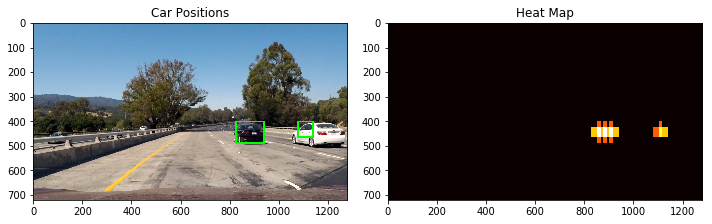

In [415]:
_ = process(test_images[3], heatvis=True)

In [ ]:
video_output = 'test_result.mp4'
clip1 = VideoFileClip("test_video.mp4")
history_bbox_list = list()
white_clip = clip1.fl_image(process)
white_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
history_bbox_list = list()
white_clip = clip1.fl_image(process)
white_clip.write_videofile(video_output, audio=False)